In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import pickle
# import warnings
# warnings.filterwarnings("ignore")

# Reading Data

In [4]:
df_chunk = pd.read_csv('train.csv', chunksize = 500000, low_memory = False)
chunks = []

In [5]:
invalid = [0]*500000
coord_list = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'fare_amount']
def mark_invalid(chunk):
    for c in coord_list:
        for i in chunk.index:
            if(c == "pickup_longitude" or c == "dropoff_longitude"):
                if(chunk[c][i].astype(float) > -73.699215 or chunk[c][i].astype(float) < -74.257159):
#                     chunk = chunk.replace(chunk[c][i],np.nan)
#                     chunk = chunk.drop([i])
                    invalid[i%500000] = 1
            elif (c == "pickup_latitude" or c == "dropoff_latitude"):
                if(chunk[c][i].astype(float) > 40.915568 or chunk[c][i].astype(float) < 40.495992):
#                     chunk = chunk.replace(chunk[c][i],np.nan)
#                     chunk = chunk.drop([i])
                    invalid[i%500000] = 1
            elif(c == "fare_amount"):
                if(chunk[c][i] >= 200 or chunk[c][i] <= 0):
#                     chunk = chunk.drop([i])
                    invalid[i%500000] = 1
    return chunk

invalid_test = [0]*1000000
coord_list_test = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']
def mark_invalid_test(chunk):
    for c in coord_list_test:
        for i in chunk.index:
            if(c == "pickup_longitude" or c == "dropoff_longitude"):
                if(chunk[c][i].astype(float) > -73.699215 or chunk[c][i].astype(float) < -74.257159):
#                     chunk = chunk.replace(chunk[c][i],np.nan)
#                     chunk = chunk.drop([i])
                    invalid_test[i%1000000] = 1
            elif (c == "pickup_latitude" or c == "dropoff_latitude"):
                if(chunk[c][i].astype(float) > 40.915568 or chunk[c][i].astype(float) < 40.495992):
#                     chunk = chunk.replace(chunk[c][i],np.nan)
#                     chunk = chunk.drop([i])
                    invalid_test[i%1000000] = 1
    return chunk
        

In [6]:
def mark_outlier(chunk, data_1):
    outliers_indices=[]
    threshold = 3
    mean_1 = np.mean(data_1)
    std_1 = np.std(data_1)
    
#     length = len(data_1)
    for i in chunk.index:
        z_score= (data_1[i] - mean_1)/std_1 
        if np.abs(z_score) > threshold:
            outliers_indices.append(i)
    for i in outliers_indices:
#         chunk = chunk.drop([i])
        chunk['invalid'][i] = 1
    return chunk


# print(len(detect_outlier(chunks[1]['fare_amount'])))

In [7]:
def split_datetime(chunk):
    hours = []
    mins = []
    secs = []
    years = []
    months = []
    days = []
    length = len(chunk['pickup_longitude'])
    
    for i in chunk.index:
        years.append(int(chunk['pickup_datetime'][i][0:4]))
        months.append(int(chunk['pickup_datetime'][i][5:7]) - 1) # 1 is subtracted to aid in days from jan 1st calculations
        days.append(int(chunk['pickup_datetime'][i][8:10]))
        hours.append(int(chunk['pickup_datetime'][i][11:13]))
        mins.append(int(chunk['pickup_datetime'][i][14:16]))
        secs.append(int(chunk['pickup_datetime'][i][17:19]))

    chunk['years'] = years
    chunk['months'] = months
    chunk['days'] = days
    chunk['hours'] = hours
    chunk['mins'] = mins
    chunk['secs'] = secs
    
    return chunk

In [8]:
def modify_datetime(chunk):
    chunk['secs_past_midnight'] = (chunk['hours']*3600) + (chunk['mins']*60) + (chunk['secs'])
    chunk['sin_spm'] = np.sin(2*np.pi*(chunk['secs_past_midnight']/86400))
    chunk['cos_spm'] = np.cos(2*np.pi*(chunk['secs_past_midnight']/86400))
    chunk['days_past_jan1'] = (chunk['months']*30) + (chunk['days'])
    chunk['sin_dpj'] = np.sin(2*np.pi*(chunk['days_past_jan1']/365))
    chunk['cos_dpj'] = np.cos(2*np.pi*(chunk['days_past_jan1']/365))
    
    return chunk

In [9]:
def split_data(chunk):
    y = chunk['fare_amount']
    X = pd.DataFrame(chunk)
    X = X.drop(['fare_amount','key','pickup_datetime', 'years', 'months', 'days', 'hours', 'mins', 'secs', 'secs_past_midnight', 'days_past_jan1'], axis = 1)
#     X = StandardScaler().fit_transform(X)
    return (X, y)

In [10]:
def fit_model_rmse(X, y, linreg = LinearRegression()):
    X_train, X_test, y_train, y_test = train_test_split(X, y)
#     linreg = LinearRegression()
    linreg.fit(X_train, y_train)
    y_pred = linreg.predict(X_test)
    rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    return (linreg, rmse)

# X1_train, X1_test, y1_train, y1_test = train_test_split(features, target, random_state=1)

In [11]:
def save_model(model, filename): 
#     filename = 'model.sav'
    pickle.dump(model, open(filename, 'wb'))

In [12]:
def load_model(filename): 
    model = pickle.load(open(filename, 'rb'))
    return model

In [13]:
def req_columns_test(chunk):
    temp = pd.DataFrame(chunk)
    temp = temp.drop(['key','pickup_datetime', 'years', 'months', 'days', 'hours', 'mins', 'secs', 'secs_past_midnight', 'days_past_jan1'], axis = 1)
    return temp

# Reading chunks and applying functions

In [17]:
count = 0
for chunk in df_chunk:
    chunk = pd.DataFrame(chunk)
    if (count == 0):
        model = LinearRegression()
    else:
        model = load_model("model.sav")
        
    chunk = mark_invalid(chunk)
    chunk['invalid'] = invalid
    chunk.dropna(inplace = True)
    chunk = split_datetime(chunk)
    chunk = modify_datetime(chunk)
    chunk = mark_outlier(chunk, chunk['fare_amount'])
    chunk['manhattan_dist'] = abs(chunk['pickup_latitude']-chunk['dropoff_latitude']) + abs(chunk['pickup_longitude']-chunk['dropoff_longitude'])
    (X1, y1) = split_data(chunk)
    X1 = pd.DataFrame(X1)
    model, rmse = fit_model_rmse(X1, y1, model)
    save_model(model, "model.sav")
    print(rmse)
    
    if (count == 0):
        chunks.append(pd.DataFrame(chunk))
    count += 1
    if(count == 4):
        break

KeyboardInterrupt: 

In [20]:
count = 0
test_chunk = pd.read_csv('test.csv', chunksize = 1000000, low_memory = False)

In [ ]:

# print(pd.DataFrame(test_chunk).shape)
test_chunks = []
final_dfs = []
for chunk in test_chunk:
    chunk = pd.DataFrame(chunk)
    if(count == 0):
        model = load_model("model.sav")
    chunk = chunk.interpolate(method='linear', limit_direction = 'forward')
    chunk = mark_invalid_test(chunk)
    chunk['invalid'] = invalid_test
#     chunk.dropna(inplace = True)
    chunk = split_datetime(chunk)
    chunk = modify_datetime(chunk)
    chunk['manhattan_dist'] = abs(chunk['pickup_latitude']-chunk['dropoff_latitude']) + abs(chunk['pickup_longitude']-chunk['dropoff_longitude'])
    if(count == 0):
        test_chunks.append(pd.DataFrame(chunk))
#     print(chunk.shape)
    req_df = req_columns_test(chunk)
#     print(req_df.shape)
    y_pred = model.predict(req_df)
    df = pd.DataFrame({'key':chunk['key'], 'fare_amount': y_pred})
    final_dfs.append(df)
    
    count += 1
    print("Finished iteration: ", count)
print(count)

Finished iteration:  1
Finished iteration:  2
Finished iteration:  3
Finished iteration:  4


In [15]:
output = pd.concat(final_dfs)
output_status = output.to_csv("output.csv")

In [16]:
test_chunks[0].head()

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,invalid,years,months,...,hours,mins,secs,secs_past_midnight,sin_spm,cos_spm,days_past_jan1,sin_dpj,cos_dpj,manhattan_dist
0,2009-01-01 00:01:04.0000003,2009-01-01 00:01:04 UTC,-73.972484,40.742743,-73.918937,40.764496,1,0,2009,0,...,0,1,4,64,0.004654,0.999989,1,0.017213,0.999852,0.075300
1,2009-01-01 00:01:26.0000001,2009-01-01 00:01:26 UTC,-73.985850,40.722826,-73.986301,40.739347,1,0,2009,0,...,0,1,26,86,0.006254,0.999980,1,0.017213,0.999852,0.016972
2,2009-01-01 00:04:42.0000001,2009-01-01 00:04:42 UTC,-73.988917,40.740142,-73.982769,40.777291,1,0,2009,0,...,0,4,42,282,0.020506,0.999790,1,0.017213,0.999852,0.043297
3,2009-01-01 00:04:54.0000001,2009-01-01 00:04:54 UTC,-73.977163,40.764490,-73.914474,40.771575,1,0,2009,0,...,0,4,54,294,0.021379,0.999771,1,0.017213,0.999852,0.069774
4,2009-01-01 00:04:59.0000004,2009-01-01 00:04:59 UTC,-73.948849,40.778003,-73.977678,40.748692,2,0,2009,0,...,0,4,59,299,0.021742,0.999764,1,0.017213,0.999852,0.058140


In [17]:
# test_chunks[0].describe()

In [18]:
# test_chunks[0].isnull().sum()

# Visualization plots 

AxesSubplot(0.125,0.125;0.775x0.755)


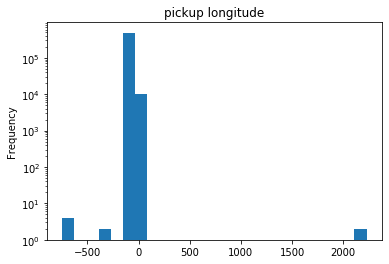

In [19]:
fig, ax = plt.subplots()
print(chunks[0]["pickup_longitude"].plot.hist(ax = ax, title="pickup longitude",bottom=1, bins=25))
ax.set_yscale('log')

AxesSubplot(0.125,0.125;0.775x0.755)


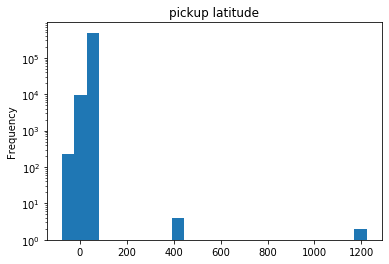

In [20]:
fig, ax = plt.subplots()
print(chunks[0]["pickup_latitude"].plot.hist(ax = ax, title="pickup latitude",bottom=1, bins=25))
ax.set_yscale('log')

AxesSubplot(0.125,0.125;0.775x0.755)


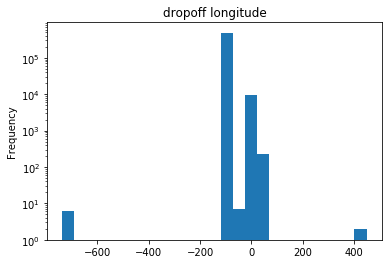

In [21]:
fig, ax = plt.subplots()
print(chunks[0]["dropoff_longitude"].plot.hist(ax = ax, title="dropoff longitude",bottom=1, bins=25))
ax.set_yscale('log')

AxesSubplot(0.125,0.125;0.775x0.755)


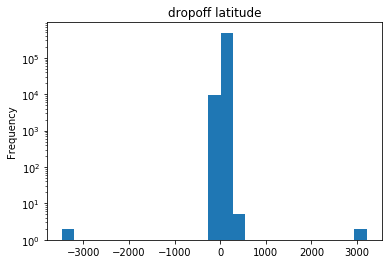

In [22]:
fig, ax = plt.subplots()
print(chunks[0]["dropoff_latitude"].plot.hist(ax = ax, title="dropoff latitude",bottom=1, bins=25))
ax.set_yscale('log')

AxesSubplot(0.125,0.125;0.775x0.755)


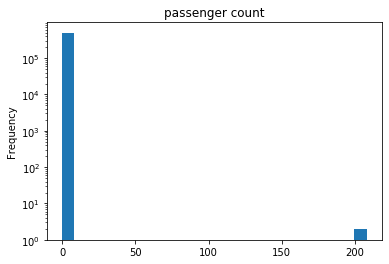

In [23]:
fig, ax = plt.subplots()
print(chunks[0]["passenger_count"].plot.hist(ax = ax, title="passenger count",bottom=1, bins=25))
ax.set_yscale('log')

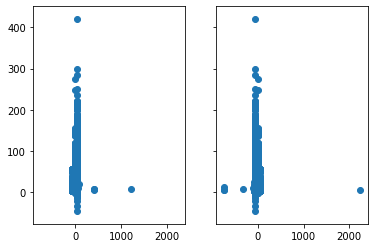

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex = True, sharey = True)
ax1.scatter(chunks[0]["pickup_latitude"],chunks[0]["fare_amount"])
# ax1.xlabel("pickup_latitude")
# ax1.ylabel("fare_amount")
ax2.scatter(chunks[0]["pickup_longitude"],chunks[0]["fare_amount"])
# ax2.xlabel("pickup_longitude")
# ax2.ylabel("fare_amount")
plt.show()

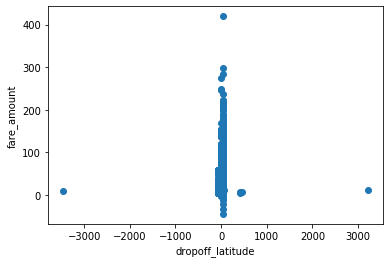

In [25]:
plt.scatter(chunks[0]["dropoff_latitude"],chunks[0]["fare_amount"])
plt.xlabel("dropoff_latitude")
plt.ylabel("fare_amount")
plt.show()

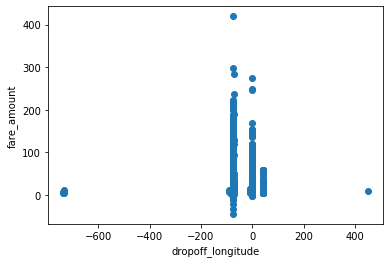

In [26]:
plt.scatter(chunks[0]["dropoff_longitude"],chunks[0]["fare_amount"])
plt.xlabel("dropoff_longitude")
plt.ylabel("fare_amount")
plt.show()

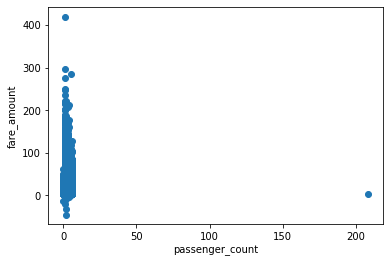

In [27]:
plt.scatter(chunks[0]["passenger_count"],chunks[0]["fare_amount"])
plt.xlabel("passenger_count")
plt.ylabel("fare_amount")
plt.show()

# Detecting Outliers

{'whiskers': [<matplotlib.lines.Line2D at 0x7fca82b26588>,
 'caps': [<matplotlib.lines.Line2D at 0x7fca82b26940>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fca82b26e80>],
 'medians': [<matplotlib.lines.Line2D at 0x7fca82b124e0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fca82b12828>],
 'means': []}

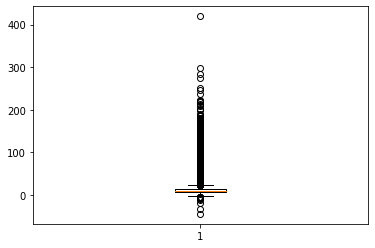

In [28]:
plt.boxplot(chunks[0].fare_amount)

In [29]:
chunks[0].to_csv('preprocessed.csv')
chunk1 = pd.read_csv('preprocessed.csv')
chunks.append(chunk1)
chunks[1].head()
chunks[0].describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,invalid,years,months,days,hours,mins,secs,secs_past_midnight,sin_spm,cos_spm,days_past_jan1,sin_dpj,cos_dpj,manhattan_dist
count,499999.000000,499999.000000,499999.000000,499999.000000,499999.000000,499999.000000,499999.000000,499999.000000,499999.000000,499999.000000,499999.000000,499999.000000,499999.000000,499999.000000,499999.000000,499999.000000,499999.000000,499999.000000,499999.000000,499999.000000
mean,11.321287,-72.494929,39.921749,-72.504527,39.920973,1.683357,0.048042,2011.735565,5.266735,15.717635,13.516307,29.596623,15.789300,50450.292009,-0.203881,-0.042835,173.719671,0.056962,-0.014769,0.292688
std,9.746025,11.083106,6.383738,10.679479,9.106300,1.337968,0.213855,1.860802,3.434141,8.686468,6.512363,17.349778,19.416183,23466.856150,0.652657,0.728449,103.262261,0.714617,0.697038,11.109569
min,-45.000000,-745.950000,-74.016400,-736.533332,-3461.540872,0.000000,0.000000,2009.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,1.000000,-0.999991,-0.999963,0.000000
25%,6.000000,-73.992057,40.735061,-73.991411,40.734087,1.000000,0.000000,2010.000000,2.000000,8.000000,9.000000,15.000000,0.000000,33900.000000,-0.817103,-0.773932,86.000000,-0.674444,-0.708627,0.015826
50%,8.500000,-73.981837,40.752657,-73.980164,40.753070,1.000000,0.000000,2012.000000,5.000000,16.000000,14.000000,30.000000,3.000000,52789.000000,-0.337917,-0.106626,166.000000,0.154309,-0.012910,0.027633
75%,12.500000,-73.967202,40.767083,-73.963785,40.768047,2.000000,0.000000,2013.000000,8.000000,23.000000,19.000000,45.000000,31.000000,70320.000000,0.362438,0.713250,264.000000,0.758306,0.677615,0.050235
max,419.750000,2228.722048,1222.118478,448.905230,3210.337087,208.000000,1.000000,2015.000000,11.000000,31.000000,23.000000,59.000000,59.000000,86399.000000,1.000000,1.000000,361.000000,0.999991,0.999852,5455.431537


In [30]:
# indices = detect_outlier(chunks[1]['fare_amount'])
# for i in indices:
#     chunks[1] = chunks[1].drop([i])
#     print(i)

In [31]:
chunks[1].to_csv('preprocessed1.csv')
chunks.append(pd.read_csv('preprocessed1.csv'))

# Restricting coordinates to NYC

All coordinates outside NYC are directly dropped

# Removing all rows with null values

In [32]:
# type(chunks[0])
# print(chunks[0].isnull().sum())
# chunks[0].dropna(inplace = True)
# print(chunks[0].isnull().sum())
# chunks[0]['pickup_datetime'][0]
# chunks[0].describe()
# type(chunks[0]['dropoff_longitude'][161652])

# Splitting pickup date time 

# Generating secs after midnight and days past jan 1st

In [33]:
# chunks[0] = chunks[0].drop(['Unnamed: 0', 'Unnamed: 0.1'], axis = 1)
chunks[1].head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,invalid,...,hours,mins,secs,secs_past_midnight,sin_spm,cos_spm,days_past_jan1,sin_dpj,cos_dpj,manhattan_dist
0,0,2014-09-27 15:26:00.00000043,7.5,2014-09-27 15:26:00 UTC,-73.978463,40.759072,-73.963577,40.774255,1,0,...,15,26,0,55560,-0.782608,-0.622515,267,-0.993257,-0.115935,0.030069
1,1,2012-05-07 07:57:00.000000142,6.5,2012-05-07 07:57:00 UTC,-73.982397,40.770245,-73.972450,40.764062,1,0,...,7,57,0,28620,0.872496,-0.488621,127,0.816538,-0.577292,0.016130
2,2,2009-05-05 20:02:36.0000005,12.9,2009-05-05 20:02:36 UTC,-74.006507,40.718808,-73.961096,40.760711,1,0,...,20,2,36,72156,-0.860297,0.509792,125,0.835925,-0.548843,0.087314
3,3,2010-07-15 22:57:00.00000042,20.1,2010-07-15 22:57:00 UTC,-73.999242,40.734165,-73.972597,40.751228,2,0,...,22,57,0,82620,-0.271440,0.962455,195,-0.213521,-0.976938,0.043708
4,4,2010-08-31 13:15:00.00000028,4.1,2010-08-31 13:15:00 UTC,-73.977750,40.746274,-73.972760,40.755768,1,0,...,13,15,0,47700,-0.321439,-0.946930,241,-0.845249,-0.534373,0.014484


In [34]:
# chunks[0]['manhattan_dist'] = abs(chunks[0]['pickup_latitude']-chunks[0]['dropoff_latitude']) + abs(chunks[0]['pickup_longitude']-chunks[0]['dropoff_longitude'])

In [35]:
chunks[0].head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,invalid,years,...,hours,mins,secs,secs_past_midnight,sin_spm,cos_spm,days_past_jan1,sin_dpj,cos_dpj,manhattan_dist
0,2014-09-27 15:26:00.00000043,7.5,2014-09-27 15:26:00 UTC,-73.978463,40.759072,-73.963577,40.774255,1,0,2014,...,15,26,0,55560,-0.782608,-0.622515,267,-0.993257,-0.115935,0.030069
1,2012-05-07 07:57:00.000000142,6.5,2012-05-07 07:57:00 UTC,-73.982397,40.770245,-73.972450,40.764062,1,0,2012,...,7,57,0,28620,0.872496,-0.488621,127,0.816538,-0.577292,0.016130
2,2009-05-05 20:02:36.0000005,12.9,2009-05-05 20:02:36 UTC,-74.006507,40.718808,-73.961096,40.760711,1,0,2009,...,20,2,36,72156,-0.860297,0.509792,125,0.835925,-0.548843,0.087314
3,2010-07-15 22:57:00.00000042,20.1,2010-07-15 22:57:00 UTC,-73.999242,40.734165,-73.972597,40.751228,2,0,2010,...,22,57,0,82620,-0.271440,0.962455,195,-0.213521,-0.976938,0.043708
4,2010-08-31 13:15:00.00000028,4.1,2010-08-31 13:15:00 UTC,-73.977750,40.746274,-73.972760,40.755768,1,0,2010,...,13,15,0,47700,-0.321439,-0.946930,241,-0.845249,-0.534373,0.014484


In [36]:
# features = chunks[0].drop(['fare_amount','key','pickup_datetime', 'years', 'months', 'days', 'hours', 'mins', 'secs', 'secs_past_midnight', 'days_past_jan1'], axis = 1)
# target = chunks[0]['fare_amount']
# features = StandardScaler().fit_transform(features)

# pca = PCA(n_components=6)
# principalComponents = pca.fit_transform(features)
# principalDf = pd.DataFrame(data = principalComponents, columns = ['PrincipalC1', 'PrincipalC2', 'PrincipalC3','PrincipalC4', 'PrincipalC5', 'PrincipalC6'])
# finalDf = pd.concat([principalDf, target], axis=1)
# finalDf.head()
# chunks[0].head()

# Generating X and y

# Test train split & Linear Regression & RMSE

In [37]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

# print(X1_train.shape)
# print(y1_train.shape)
# print(X1_test.shape)
# print(y1_test.shape)

NameError: name 'X_train' is not defined

# Applying Linear Regression

In [ ]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

In [ ]:
# linreg1 = LinearRegression()
# linreg1.fit(X1_train, y1_train)

## Predicting outputs

In [ ]:
y_pred = linreg.predict(X_test)
# y1_pred = linreg1.predict(X1_test)

## Generating RMSE

In [ ]:
print("Without PCA: ", np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
# print("With PCA: ", np.sqrt(metrics.mean_squared_error(y1_test, y1_pred)))